## Project 2

https://github.com/DX0ZART/Group_3

### Load Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3, EfficientNetB0

# from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

### 0. Data Loading and Preprocessing

#### Load Data

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
# print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]


In [ ]:
# Reduce number of images to first 1345 for each category
# fnames[0]=fnames[0][0:1344]
# fnames[1]=fnames[1][0:1344]
# fnames[2]=fnames[2][0:1344]

#### Preprocessing

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
    img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, split it into rgb layers
    img = (np.float32(img)-1.)/(255-1.) # min max transformation
    img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
    return img

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of data

# aggregate filepath
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# cast the list into array for Keras
X= np.array(preprocessed_image_data)

In [ ]:
len(image_filepaths)

15153

In [ ]:
print(len(X) ) #double check the numbers if the files
print(X.shape ) #making sure the dimensions for all images are correct
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


15153
(15153, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1345

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", len(fnames[0])))
normal=list(repeat("NORMAL", len(fnames[1])))
pneumonia=list(repeat("PNEUMONIA", len(fnames[2])))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [3616, 10192, 1345]
15153


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
15148,False,False,True
15149,False,False,True
15150,False,False,True
15151,False,False,True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8425197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8897638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].


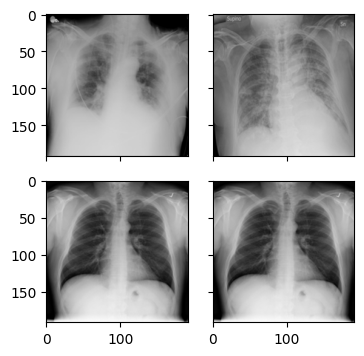

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    ax.imshow(im)
plt.show()

#### Train Test Split

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

((4849, 192, 192, 3), (4849, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

#### Save to Files

In [ ]:
#Save data to be able to reload quickly if crashes
import pickle

with open('data/X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

with open('data/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('data/y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('data/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

### 1. Dataset and Exploratory Data Analysis

#### Load Data

In [ ]:
import pickle

# Open the file in binary mode
with open('data/X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('data/y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

# Open the file in binary mode
with open('data/X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('data/y_test.pkl', 'rb') as file:
    # Call load method to deserialze
    y_test = pickle.load(file)

#### Describe the dataset - basic statistics

In [ ]:
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# Dataset Overview
print("Dataset Description:")
print("This dataset contains chest X-ray images for COVID-19 classification.")
print("The images are categorized into three classes:")
print("  1. COVID: X-rays showing COVID-19 positive cases")
print("  2. NORMAL: X-rays from healthy individuals")
print("  3. PNEUMONIA: X-rays showing viral pneumonia (non-COVID)")
print("=" * 80)
# Class Labels
print("CLASS LABELS:")
print(f"Number of classes: {y_train.shape[1]}")
print(f"Class names: {list(y_train.columns)}")

Dataset Description:
This dataset contains chest X-ray images for COVID-19 classification.
The images are categorized into three classes:
  1. COVID: X-rays showing COVID-19 positive cases
  2. NORMAL: X-rays from healthy individuals
  3. PNEUMONIA: X-rays showing viral pneumonia (non-COVID)
CLASS LABELS:
Number of classes: 3
Class names: ['COVID', 'NORMAL', 'PNEUMONIA']


In [ ]:
# Data Dimensions
print("DATA DIMENSIONS:")
print(f"Training Set:")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - Number of training samples: {X_train.shape[0]:,}")
print(f"Test Set:")
print(f"  - X_test shape: {X_test.shape}")
print(f"  - y_test shape: {y_test.shape}")
print(f"  - Number of test samples: {X_test.shape[0]:,}")
print(f"Total Dataset Size: {X_train.shape[0] + X_test.shape[0]:,} images")
print(f"Image Properties:")
print(f"  - Image dimensions: {X_train.shape[1]} x {X_train.shape[2]} pixels")
print(f"  - Color channels: {X_train.shape[3]} (RGB)")
print(f"  - Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}] (normalized)")

DATA DIMENSIONS:
Training Set:
  - X_train shape: (10304, 192, 192, 3)
  - y_train shape: (10304, 3)
  - Number of training samples: 10,304
Test Set:
  - X_test shape: (4849, 192, 192, 3)
  - y_test shape: (4849, 3)
  - Number of test samples: 4,849
Total Dataset Size: 15,153 images
Image Properties:
  - Image dimensions: 192 x 192 pixels
  - Color channels: 3 (RGB)
  - Pixel value range: [-0.004, 1.000] (normalized)


#### Basic Statistics - Image Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8307087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8543307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.9488189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.96062994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.96456695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

Sample images from the training set:


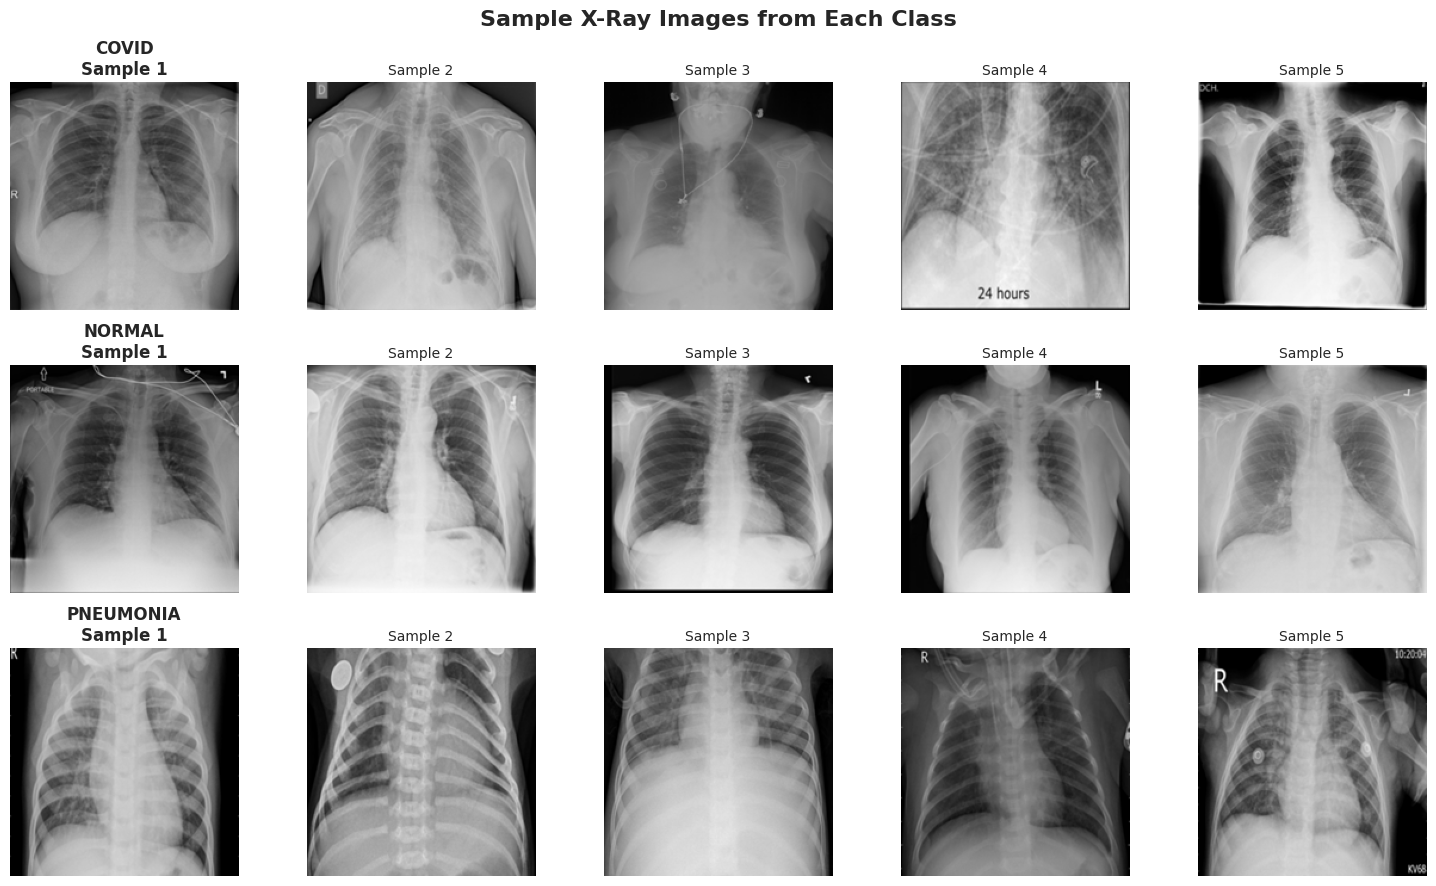

In [ ]:
def display_class_samples(X, y, n_samples=5):
    classes = y.columns.tolist()
    n_classes = len(classes)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=(n_samples * 3, n_classes * 3))
    fig.suptitle('Sample X-Ray Images from Each Class', fontsize=16, fontweight='bold', y=0.98)

    for i, class_name in enumerate(classes):
        class_indices = np.where(y[class_name] == 1)[0]
        sample_indices = np.random.choice(class_indices, n_samples, replace=False)

        for j, idx in enumerate(sample_indices):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            ax.imshow(X[idx])
            ax.axis('off')

            if j == 0:
                ax.set_title(f'{class_name}\nSample {j+1}', fontweight='bold', fontsize=12)
            else:
                ax.set_title(f'Sample {j+1}', fontsize=10)

    plt.tight_layout()
    plt.show()

print("Sample images from the training set:")
display_class_samples(X_train, y_train, n_samples=5)

#### Check Class Balance

In [ ]:
# Calculate class distribution
train_class_counts = y_train.sum().to_dict()
test_class_counts = y_test.sum().to_dict()
total_class_counts = {k: train_class_counts[k] + test_class_counts[k] for k in train_class_counts}

# Create DataFrame for better visualization
distribution_df = pd.DataFrame({
    'Training': train_class_counts,
    'Test': test_class_counts,
    'Total': total_class_counts
})

# Calculate percentages
distribution_df['Train %'] = (distribution_df['Training'] / distribution_df['Training'].sum() * 100).round(2)
distribution_df['Test %'] = (distribution_df['Test'] / distribution_df['Test'].sum() * 100).round(2)
distribution_df['Total %'] = (distribution_df['Total'] / distribution_df['Total'].sum() * 100).round(2)

print("Class Distribution:")
print("-" * 80)
print(distribution_df)

print("\nDATASET IS NOT BALANCED")
print("Balancing Required")

Class Distribution:
--------------------------------------------------------------------------------
           Training  Test  Total  Train %  Test %  Total %
COVID          2459  1157   3616    23.86   23.86    23.86
NORMAL         6930  3262  10192    67.26   67.27    67.26
PNEUMONIA       915   430   1345     8.88    8.87     8.88

DATASET IS NOT BALANCED
Balancing Required


#### Strategies to Handle Class Imbalance

1. Class Weighting: Assign higher weights to minority classes during training
It does not change the dataset size and penalizes misclassifications of minority classes more heavily

2. Oversampling: Increase minority class samples (e.g., Randomly duplicate samples from minority classes to match majority class.)
3. Undersampling: Randomly remove samples from majority classes to match minority class.

4. **Augmentation**: Generate synthetic samples through transformations
- I would choose **this method**.

**Data Augmentation**:
   - Creates diverse synthetic samples without exact duplicates
   - Improves model generalization and robustness
   - Particularly effective for image data
   - Reduces overfitting risk

**Expected Performance Impact**:
- More balanced precision/recall across classes
- Better sensitivity (recall) for minority classes
- Slight decrease in overall accuracy but significant improvement in per-class metrics
- Higher F1-scores for underrepresented classes

#### Strategy: Data Augmentation

In [ ]:
idx_covid = np.where(y_train["COVID"] == 1)[0]
idx_normal = np.where(y_train["NORMAL"] == 1)[0]
idx_pneu = np.where(y_train["PNEUMONIA"] == 1)[0]

X_covid, X_normal, X_pneu = X_train[idx_covid], X_train[idx_normal], X_train[idx_pneu]
y_covid, y_normal, y_pneu = y_train.iloc[idx_covid], y_train.iloc[idx_normal], y_train.iloc[idx_pneu]

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15, # Rotation: ±15 degrees
    width_shift_range=0.1, # Width shift: ±10%
    height_shift_range=0.1, # Height shift: ±10%
    horizontal_flip=True, # Horizontal flip: Enabled
    zoom_range=0.1, # Zoom: ±10%
    fill_mode='nearest'
)

In [ ]:
def augment_class(X_class, y_class, target_size):
    n_to_generate = target_size - len(X_class)
    if n_to_generate <= 0:
        return X_class, y_class

    aug_iter = datagen.flow(X_class, y_class, batch_size=32)
    X_aug, y_aug = [], []

    for _ in range(n_to_generate // 32 + 1):
        x_batch, y_batch = next(aug_iter)
        X_aug.append(x_batch)
        y_aug.append(y_batch)
        if len(np.concatenate(X_aug)) >= target_size - len(X_class):
            break

    X_aug = np.concatenate(X_aug)[:n_to_generate]
    y_aug = np.concatenate(y_aug)[:n_to_generate]
    return np.concatenate([X_class, X_aug]), np.concatenate([y_class, y_aug])

In [ ]:
target = len(X_normal)  # 6930

X_covid_aug, y_covid_aug = augment_class(X_covid, y_covid, target)
X_pneu_aug, y_pneu_aug = augment_class(X_pneu, y_pneu, target)

In [ ]:
# In case OOM
del(X_test)
del(y_train)

In [ ]:
X_balanced = np.concatenate([X_normal, X_covid_aug, X_pneu_aug])
y_balanced = np.concatenate([y_normal, y_covid_aug, y_pneu_aug])

p = np.random.permutation(len(X_balanced))
X_train_balanced, y_train_balanced = X_balanced[p], y_balanced[p]

In [ ]:
# In case OOM
del(X_covid_aug)
del(y_covid_aug)
del(X_balanced)
del(y_balanced)
del(p)

#### Check Balance Again

In [ ]:
y_train_balanced = pd.DataFrame(y_train_balanced, columns = ["COVID", "NORMAL", "PNEUMONIA"])

In [ ]:
# Calculate class distribution
train_class_counts = y_train_balanced.sum().to_dict()
test_class_counts = y_test.sum().to_dict()
total_class_counts = {k: train_class_counts[k] + test_class_counts[k] for k in train_class_counts}

# Create DataFrame for better visualization
distribution_df = pd.DataFrame({
    'Training': train_class_counts,
    'Test': test_class_counts,
    'Total': total_class_counts
})

# Calculate percentages
distribution_df['Train %'] = (distribution_df['Training'] / distribution_df['Training'].sum() * 100).round(2)
distribution_df['Test %'] = (distribution_df['Test'] / distribution_df['Test'].sum() * 100).round(2)
distribution_df['Total %'] = (distribution_df['Total'] / distribution_df['Total'].sum() * 100).round(2)

print("Class Distribution:")
print("-" * 80)
print(distribution_df)

print("\nDATASET IS NOW BALANCED")

Class Distribution:
--------------------------------------------------------------------------------
           Training  Test  Total  Train %  Test %  Total %
COVID          6930  1157   8087    33.46   23.86    31.64
NORMAL         6930  3262  10192    33.46   67.27    39.87
PNEUMONIA      6853   430   7283    33.09    8.87    28.49

DATASET IS NOW BALANCED


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8098158].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038251434..0.9629155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038858745..0.9592573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.9869442].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.9843035].


Example of augmented images:
(Original image followed by augmented versions)



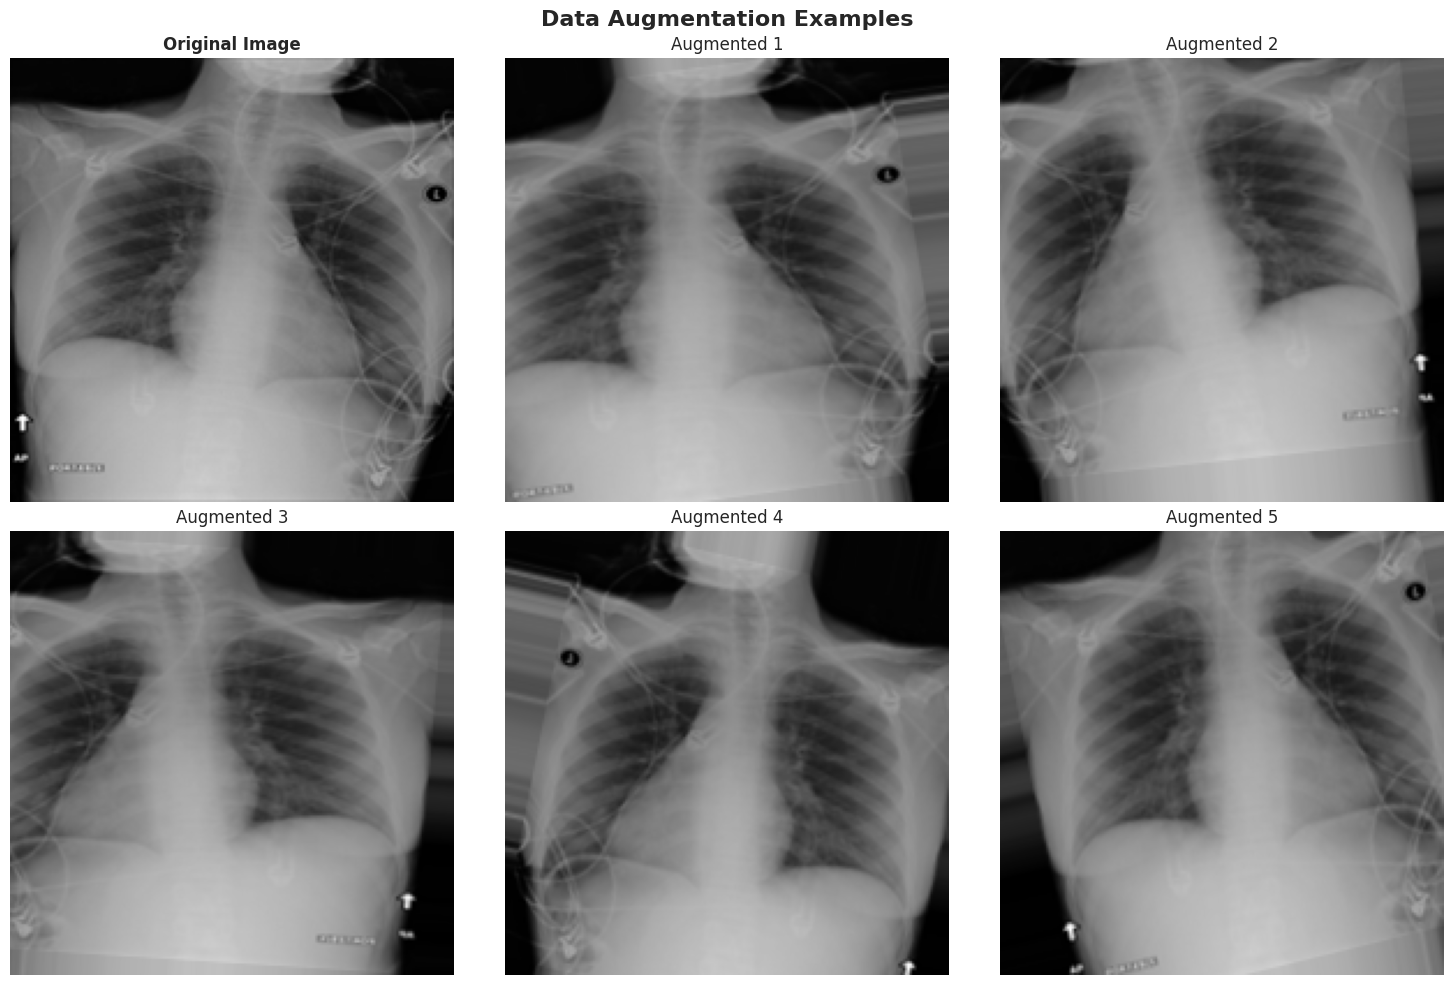

In [ ]:
# Visualize augmented samples
print("Example of augmented images:")
print("(Original image followed by augmented versions)\n")

sample_image = X_train[0:1]  # Keep batch dimension

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Show original
axes[0].imshow(sample_image[0])
axes[0].set_title('Original Image', fontweight='bold', fontsize=12)
axes[0].axis('off')

# Generate and show augmented versions
datagen.fit(sample_image)
for i, batch in enumerate(datagen.flow(sample_image, batch_size=1)):
    if i >= 5:
        break
    axes[i+1].imshow(batch[0])
    axes[i+1].set_title(f'Augmented {i+1}', fontsize=12)
    axes[i+1].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

#### Save to Files

In [ ]:
# In case OOM
del(X_train)
del(y_test)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('data/X_train_balanced.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train_balanced, file)

with open('data/y_train_balanced.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train_balanced, file)

#### Real-World Impact and Beneficiaries

This COVID-19 X-ray classification model has significant practical applications:

**1. Healthcare Providers:**
- **Emergency Departments**: Rapid triage of patients with respiratory symptoms
- **Radiologists**: AI-assisted diagnosis to reduce workload and catch missed cases
- **Telemedicine**: Remote diagnosis support for areas without specialist access

**2. Public Health:**
- **Outbreak Monitoring**: Early detection of COVID-19 clusters in communities
- **Resource Allocation**: Prioritizing limited RT-PCR tests for high-risk cases

**3. Patients:**
- **Faster Diagnosis**: Reduced wait time for results (minutes vs. hours/days)
- **Early Treatment**: Quicker initiation of appropriate care

### 2. Baseline CNN Model

#### Clean Memory

In [ ]:
import gc
gc.collect()

0

In [ ]:
# Load preprocessed data
import pickle

with open('data/X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('data/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('data/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('data/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (10304, 192, 192, 3)
Training labels shape: (10304, 3)
Test data shape: (4849, 192, 192, 3)
Test labels shape: (4849, 3)


In [ ]:
# Create validation split from training data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15,
    random_state=42,
    stratify=y_train
)

print(f"Training split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val.shape}")
print(f"Test split shape: {X_test.shape}")

Training split shape: (8758, 192, 192, 3)
Validation split shape: (1546, 192, 192, 3)
Test split shape: (4849, 192, 192, 3)


#### Baseline: basic Convolutional Neural Network

Architecture:
- 3 Convolutional blocks (Conv2D → BatchNorm → MaxPooling → Dropout)
- Dense layers with dropout for classification
- Output layer with softmax for 3-class classification

Configuration:
- Loss Function: Categorical Crossentropy (multi-class classification)
- Optimizer: Adam (learning_rate=0.001)
- Metrics: Accuracy, Precision, Recall
- Batch Size: 32
- Epochs: 30 with early stopping

In [ ]:
def create_baseline_cnn(input_shape=(192, 192, 3), num_classes=3):
    """
    Create a baseline CNN model.

    Architecture:
    - Conv Block 1: 32 filters, 3x3 kernel
    - Conv Block 2: 64 filters, 3x3 kernel
    - Conv Block 3: 128 filters, 3x3 kernel
    - Dense Layer: 256 units
    - Output Layer: 3 units (softmax)
    """
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ], name='Baseline_CNN')

    return model

In [ ]:
# Create and compile the baseline model
baseline_model = create_baseline_cnn()

baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

baseline_model.summary()

/mnt/f/BaiduSyncdisk/1_Classes/3_25Fall/1_ADS/HW/HW_3A_Due_2025.10.12/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761860552.692695   32050 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 192, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,198,243 (73.24 MB)

 Trainable params: 19,196,579 (73.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Setup callbacks
def setup_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        min_delta=1e-3,
        patience=8,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    return [early_stopping, reduce_lr]

In [ ]:
def save_model(model, model_name, model_history, test_results):
    import json
    import os
    os.makedirs("out", exist_ok=True)
    os.makedirs("out/model", exist_ok=True)
    os.makedirs("out/model_history", exist_ok=True)
    os.makedirs("out/test_result", exist_ok=True)

    model.save(f"out/model/{model_name}_model.h5")
    history_dict = getattr(model_history, "history", model_history)
    with open(f"out/model_history/{model_name}_history.json", "w") as f:
        json.dump(history_dict, f, indent=2)

    with open(f"out/test_result/{model_name}_test_result.json", "w") as f:
        json.dump(test_results, f, indent=2)

In [ ]:
# Train the baseline model
print("Training Baseline CNN...")
baseline_history = baseline_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)

Training Baseline CNN...
Epoch 1/30


2025-10-30 17:42:44.411230: I external/local_xla/xla/service/service.cc:163] XLA service 0x71b7440036f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 17:42:44.411265: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-10-30 17:42:44.505560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 17:42:44.886361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-30 17:42:45.184248: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:42:45.184589: I e

  3/274 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.3854 - loss: 1.5619 - precision: 0.3870 - recall: 0.3438

I0000 00:00:1761860571.217336   32196 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6530 - loss: 1.0029 - precision: 0.6720 - recall: 0.6266

2025-10-30 17:42:57.471757: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:42:57.471803: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:42:57.659140: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4468', 4 bytes spill stores, 4 bytes spill loads

2025-10-30 17:42:57.751806: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.7491 - loss: 0.7348 - precision: 0.7658 - recall: 0.7286 - val_accuracy: 0.2581 - val_loss: 6.4320 - val_precision: 0.2581 - val_recall: 0.2581 - learning_rate: 0.0010
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8657 - loss: 0.3750 - precision: 0.8719 - recall: 0.8570 - val_accuracy: 0.3693 - val_loss: 2.2272 - val_precision: 0.3681 - val_recall: 0.3376 - learning_rate: 0.0010
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8848 - loss: 0.3162 - precision: 0.8888 - recall: 0.8771 - val_accuracy: 0.7154 - val_loss: 1.2481 - val_precision: 0.7154 - val_recall: 0.7154 - learning_rate: 0.0010
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9205 - loss: 0.2203 - precision: 0.9240 - recall: 0.9168 - val_accuracy: 0.8732 - val_loss: 0.3465 - val_precision: 0.8770 - val_recall: 0.8668 - learning_rate: 0.0010
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9

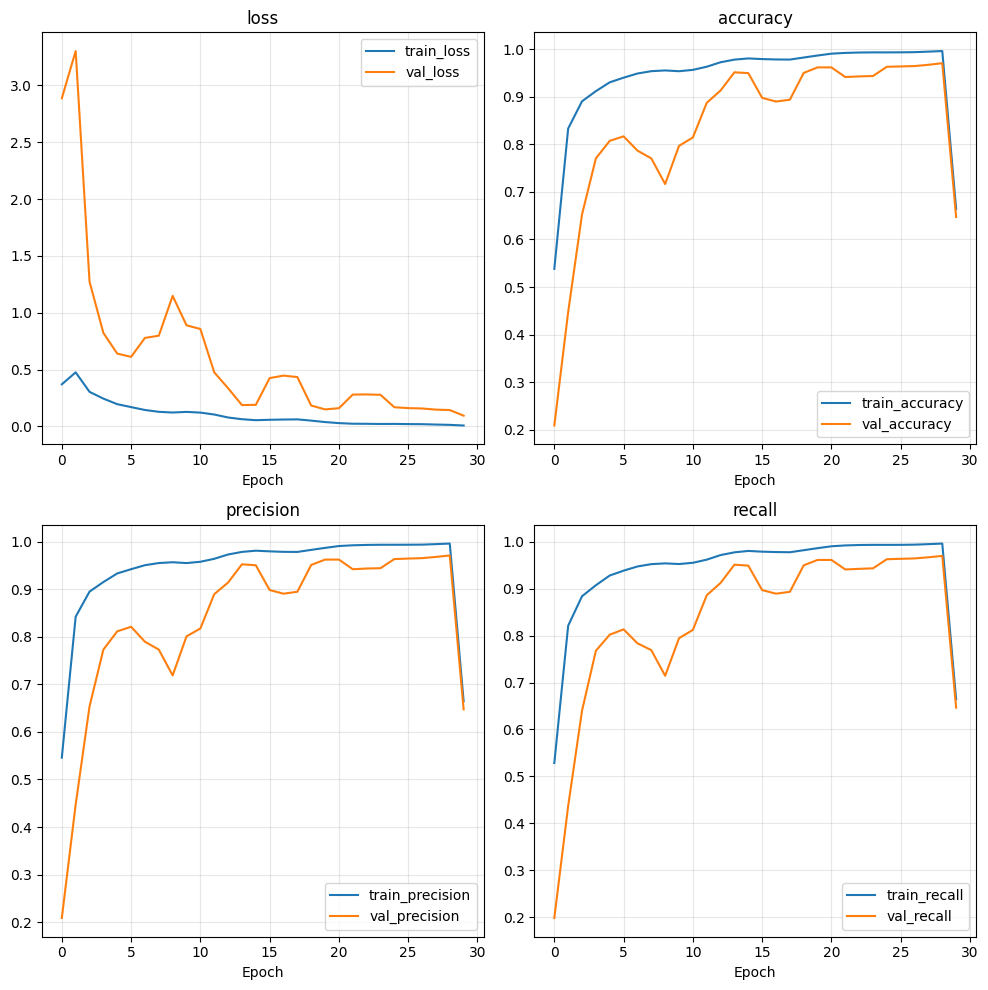

In [ ]:
# Define a helper function to smooth training curves using a simple moving average
def smooth(xs, w=3):
    if w <= 1: return xs
    xs = np.array(xs, dtype=float)
    return np.convolve(xs, np.ones(w)/w, mode='same')

metrics = [
    ('loss', 'val_loss'),
    ('accuracy', 'val_accuracy'),
    ('precision', 'val_precision'),
    ('recall', 'val_recall'),
]

plt.figure(figsize=(10, 10))
for i, (m, vm) in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    train_curve = baseline_history.history .get(m, [])
    val_curve   = baseline_history.history .get(vm, [])
    w = 3
    plt.plot(smooth(train_curve, w=w), label=f'train_{m}')
    plt.plot(smooth(val_curve,   w=w), label=f'val_{m}')
    plt.title(m)
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
print("\nBaseline CNN - Test Set Evaluation:")
baseline_test_loss, baseline_test_acc, baseline_test_prec, baseline_test_recall = baseline_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {baseline_test_acc:.4f}")
print(f"Test Precision: {baseline_test_prec:.4f}")
print(f"Test Recall: {baseline_test_recall:.4f}")
print(f"Test F1-Score: {2 * (baseline_test_prec * baseline_test_recall) / (baseline_test_prec + baseline_test_recall):.4f}")

test_results = {
    "model_name": "Baseline_CNN",
    "test_loss": float(baseline_test_loss),
    "test_accuracy": float(baseline_test_acc),
    "test_precision": float(baseline_test_prec),
    "test_recall": float(baseline_test_recall),
    "test_f1": float(2 * (baseline_test_prec * baseline_test_recall) / (baseline_test_prec + baseline_test_recall))
}


Baseline CNN - Test Set Evaluation:
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9800 - loss: 0.0639 - precision: 0.9801 - recall: 0.9796

2025-10-30 17:46:31.106193: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:46:31.303204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_260', 16 bytes spill stores, 16 bytes spill loads



152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9810 - loss: 0.0715 - precision: 0.9812 - recall: 0.9806
Test Accuracy: 0.9810
Test Precision: 0.9812
Test Recall: 0.9806
Test F1-Score: 0.9809


In [ ]:
save_model(baseline_model, "baseline_model", baseline_history, test_results)

### 3. Transfer Learning with ResNet

Approach:
1. Load ResNet50 without top layers
2. Freeze base layers initially
3. Add custom classification head
4. Fine-tune top layers after initial training

**Fine-tuning:** Unfreeze last 20 layers

In [ ]:
def create_resnet_model(input_shape=(192, 192, 3), num_classes=3, fine_tune=False):
    """
    Create ResNet50 transfer learning model.
    """
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = fine_tune

    if fine_tune:
        # Fine-tune from layer 140 onwards
        for layer in base_model.layers[:140]:
            layer.trainable = False

    # Build model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name='ResNet50_Transfer')

    return model

In [ ]:
# Create ResNet model
resnet_model = create_resnet_model(fine_tune=False)

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print(f"Total layers: {len(resnet_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in resnet_model.layers])}")

Total layers: 9
Trainable layers: 8


In [ ]:
# Train ResNet model
print("Training ResNet50 (frozen base)...")
resnet_history = resnet_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)

Training ResNet50 (frozen base)...
Epoch 1/30


2025-10-30 17:47:28.201459: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:47:28.201513: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:47:28.201528: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:47:28.201534: I external/l

271/274 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4488 - loss: 1.5123 - precision: 0.4626 - recall: 0.4033

2025-10-30 17:47:35.017777: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:47:35.017823: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:47:35.303363: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5767', 16 bytes spill stores, 16 bytes spill loads

2025-10-30 17:47:35.333835: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.4953 - loss: 1.3647 - precision: 0.5118 - recall: 0.4498 - val_accuracy: 0.2497 - val_loss: 1.1945 - val_precision: 0.4770 - val_recall: 0.0873 - learning_rate: 1.0000e-04
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6068 - loss: 1.0289 - precision: 0.6326 - recall: 0.5669 - val_accuracy: 0.4864 - val_loss: 0.9195 - val_precision: 0.4865 - val_recall: 0.4437 - learning_rate: 1.0000e-04
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6728 - loss: 0.8489 - precision: 0.6969 - recall: 0.6368 - val_accuracy: 0.1429 - val_loss: 2.0124 - val_precision: 0.1416 - val_recall: 0.1404 - learning_rate: 1.0000e-04
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7191 - loss: 0.7273 - precision: 0.7433 - recall: 0.6867 - val_accuracy: 0.2691 - val_loss: 3.3213 - val_precision: 0.2681 - val_recall: 0.2665 - learning_rate: 1.0000e-04
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step -

In [ ]:
# Fine-tune the model
print("\nFine-tuning ResNet50...")

# Unfreeze last layers
for layer in resnet_model.layers[0].layers[-20:]:
    layer.trainable = True

# Recompile with lower learning rate
resnet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

resnet_history_finetune = resnet_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)


Fine-tuning ResNet50...
Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.8139 - loss: 0.4967 - precision: 0.8225 - recall: 0.8049 - val_accuracy: 0.1514 - val_loss: 1.9722 - val_precision: 0.1487 - val_recall: 0.1442 - learning_rate: 1.0000e-05
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8647 - loss: 0.3569 - precision: 0.8711 - recall: 0.8566 - val_accuracy: 0.8169 - val_loss: 0.4865 - val_precision: 0.8374 - val_recall: 0.8027 - learning_rate: 1.0000e-05
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8940 - loss: 0.2923 - precision: 0.8986 - recall: 0.8870 - val_accuracy: 0.8816 - val_loss: 0.3171 - val_precision: 0.8838 - val_recall: 0.8758 - learning_rate: 1.0000e-05
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8971 - loss: 0.2663 - precision: 0.9032 - recall: 0.8929 - val_accuracy: 0.9185 - val_loss: 0.2386 - val_precision: 0.9207 - val_recall: 0.9166 - learning_rate: 1.0000e-05
Epoch 5/15
274/274

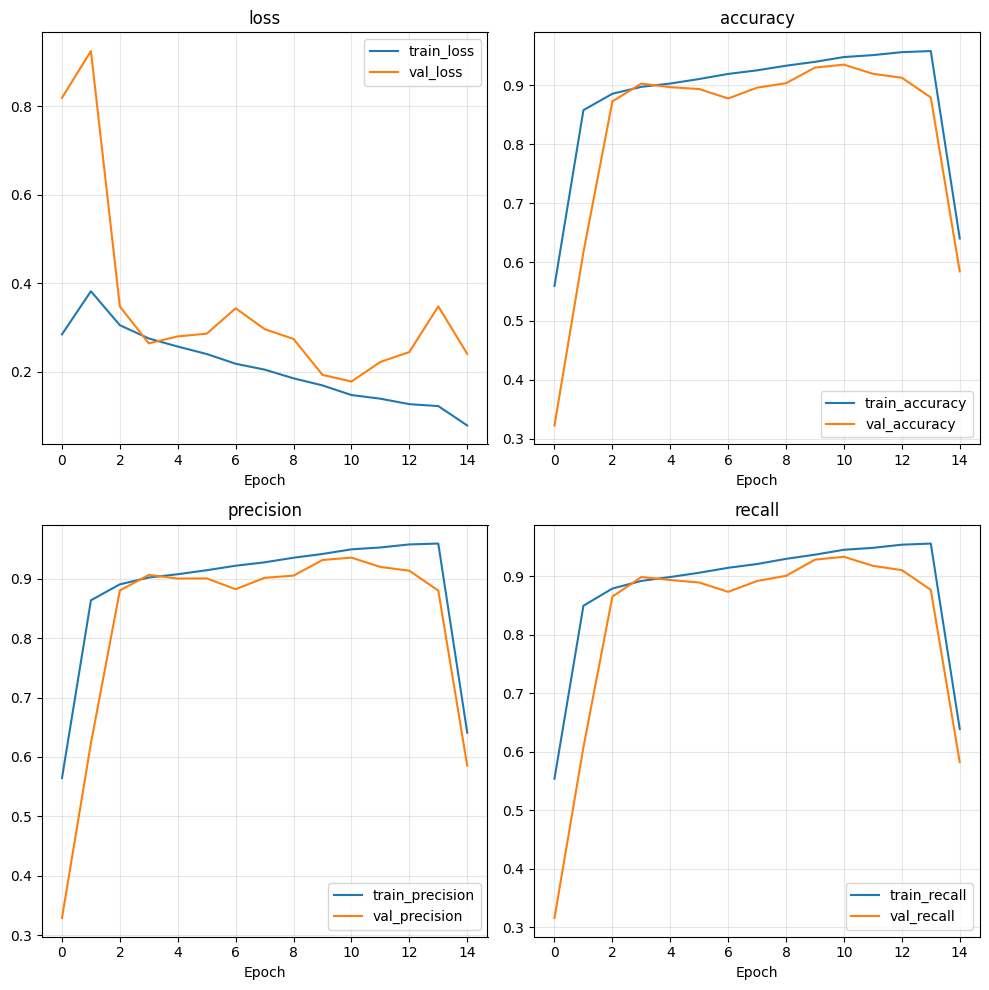

In [ ]:
#helper function used previously
def smooth(xs, w=3):
    if w <= 1: return xs
    xs = np.array(xs, dtype=float)
    return np.convolve(xs, np.ones(w)/w, mode='same')

metrics = [
    ('loss', 'val_loss'),
    ('accuracy', 'val_accuracy'),
    ('precision', 'val_precision'),
    ('recall', 'val_recall'),
]

plt.figure(figsize=(10, 10))
for i, (m, vm) in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    train_curve = resnet_history_finetune.history .get(m, [])
    val_curve   = resnet_history_finetune.history .get(vm, [])
    w = 3
    plt.plot(smooth(train_curve, w=w), label=f'train_{m}')
    plt.plot(smooth(val_curve,   w=w), label=f'val_{m}')
    plt.title(m)
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate ResNet on test set
print("\nResNet50 - Test Set Evaluation:")
resnet_test_loss, resnet_test_acc, resnet_test_prec, resnet_test_recall = resnet_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {resnet_test_acc:.4f}")
print(f"Test Precision: {resnet_test_prec:.4f}")
print(f"Test Recall: {resnet_test_recall:.4f}")
print(f"Test F1-Score: {2 * (resnet_test_prec * resnet_test_recall) / (resnet_test_prec + resnet_test_recall):.4f}")

test_results = {
    "model_name": "ResNet50",
    "test_loss": float(resnet_test_loss),
    "test_accuracy": float(resnet_test_acc),
    "test_precision": float(resnet_test_prec),
    "test_recall": float(resnet_test_recall),
    "test_f1": float(2 * (resnet_test_prec * resnet_test_recall) / (resnet_test_prec + resnet_test_recall))
}


ResNet50 - Test Set Evaluation:
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9418 - loss: 0.1593 - precision: 0.9428 - recall: 0.9404

2025-10-30 17:51:23.926779: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:51:24.080381: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1798', 4 bytes spill stores, 4 bytes spill loads

2025-10-30 17:51:24.158708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1787', 16 bytes spill stores, 16 bytes spill loads

2025-10-30 17:51:24.297746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1787', 8 bytes

152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9338 - loss: 0.1850 - precision: 0.9357 - recall: 0.9326
Test Accuracy: 0.9338
Test Precision: 0.9357
Test Recall: 0.9326
Test F1-Score: 0.9341


In [ ]:
save_model(resnet_model, "ResNet50", resnet_history_finetune, test_results)

**Impact of Pre-trained Features**

Benefits:
1. Faster Convergence: Pre-trained features accelerate training
2. Better Generalization: ImageNet features transfer well to medical images
3. Lower Data Requirements: Effective even with limited training data
4. Improved Performance: Typically outperforms models trained from scratch

### 4. Additional Architectures


Implement three additional models:
1. **VGG19** - Deep architecture with small filters
2. **InceptionV3** - Multi-scale feature extraction
3. **mobilenet** - Faster and light

#### Model 1: VGG19

In [ ]:
def create_vgg19_model(input_shape=(192, 192, 3), num_classes=3):
    """
    Create VGG19 transfer learning model.
    """
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name='VGG19_Transfer')

    return model

# Create and compile VGG19
vgg19_model = create_vgg19_model()
vgg19_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print("VGG19 Model Created")

VGG19 Model Created


In [ ]:
# Train VGG19
print("Training VGG19...")
vgg19_history = vgg19_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)

Training VGG19...
Epoch 1/25


2025-10-30 17:51:49.683271: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:51:49.889475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2438', 4 bytes spill stores, 4 bytes spill loads

2025-10-30 17:51:50.029843: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2438', 520 bytes spill stores, 520 bytes spill loads



274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5963 - loss: 1.1588 - precision: 0.6108 - recall: 0.5708 - val_accuracy: 0.8195 - val_loss: 0.5499 - val_precision: 0.8633 - val_recall: 0.7639 - learning_rate: 1.0000e-04
Epoch 2/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7262 - loss: 0.7887 - precision: 0.7460 - recall: 0.7060 - val_accuracy: 0.8745 - val_loss: 0.3641 - val_precision: 0.8825 - val_recall: 0.8596 - learning_rate: 1.0000e-04
Epoch 3/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7789 - loss: 0.6360 - precision: 0.7951 - recall: 0.7609 - val_accuracy: 0.9004 - val_loss: 0.2842 - val_precision: 0.9062 - val_recall: 0.8875 - learning_rate: 1.0000e-04
Epoch 4/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8115 - loss: 0.5508 - precision: 0.8247 - recall: 0.7981 - val_accuracy: 0.9004 - val_loss: 0.3271 - val_precision: 0.9041 - val_recall: 0.8900 - learning_rate: 1.0000e-04
Epoch 5/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step 

In [ ]:
# Evaluate VGG19
print("\nVGG19 - Test Set Evaluation:")
vgg19_test_loss, vgg19_test_acc, vgg19_test_prec, vgg19_test_recall = vgg19_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {vgg19_test_acc:.4f}")
print(f"Test Precision: {vgg19_test_prec:.4f}")
print(f"Test Recall: {vgg19_test_recall:.4f}")
print(f"Test F1-Score: {2 * (vgg19_test_prec * vgg19_test_recall) / (vgg19_test_prec + vgg19_test_recall):.4f}")

test_results = {
    "model_name": "VGG19",
    "test_loss": float(vgg19_test_loss),
    "test_accuracy": float(vgg19_test_acc),
    "test_precision": float(vgg19_test_prec),
    "test_recall": float(vgg19_test_recall),
    "test_f1": float(2 * (vgg19_test_prec * vgg19_test_recall) / (vgg19_test_prec + vgg19_test_recall))
}


VGG19 - Test Set Evaluation:
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9464 - loss: 0.1515 - precision: 0.9473 - recall: 0.9460
Test Accuracy: 0.9464
Test Precision: 0.9473
Test Recall: 0.9460
Test F1-Score: 0.9467


In [ ]:
save_model(vgg19_model, "VGG19", vgg19_history, test_results)

#### Model 2: InceptionV3

In [ ]:
def create_inception_model(input_shape=(192, 192, 3), num_classes=3):
    """
    Create InceptionV3 transfer learning model.
    """
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name='InceptionV3_Transfer')

    return model

# Create and compile InceptionV3
inception_model = create_inception_model()
inception_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print("InceptionV3 Model Created")

InceptionV3 Model Created


In [ ]:
# Train InceptionV3
print("Training InceptionV3...")
inception_history = inception_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)

Training InceptionV3...
Epoch 1/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.5943 - loss: 1.1937 - precision: 0.6121 - recall: 0.5691 - val_accuracy: 0.8292 - val_loss: 0.5139 - val_precision: 0.8507 - val_recall: 0.7995 - learning_rate: 1.0000e-04
Epoch 2/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7221 - loss: 0.8014 - precision: 0.7369 - recall: 0.6990 - val_accuracy: 0.8396 - val_loss: 0.4887 - val_precision: 0.8542 - val_recall: 0.8150 - learning_rate: 1.0000e-04
Epoch 3/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7810 - loss: 0.6386 - precision: 0.7981 - recall: 0.7625 - val_accuracy: 0.8829 - val_loss: 0.3445 - val_precision: 0.8866 - val_recall: 0.8752 - learning_rate: 1.0000e-04
Epoch 4/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8103 - loss: 0.5511 - precision: 0.8244 - recall: 0.7938 - val_accuracy: 0.8829 - val_loss: 0.3380 - val_precision: 0.8890 - val_recall: 0.8758 - learning_rate: 1.0000e-04
Epoch 5/25
274/274 

In [ ]:
# Evaluate InceptionV3
print("\nInceptionV3 - Test Set Evaluation:")
inception_test_loss, inception_test_acc, inception_test_prec, inception_test_recall = inception_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {inception_test_acc:.4f}")
print(f"Test Precision: {inception_test_prec:.4f}")
print(f"Test Recall: {inception_test_recall:.4f}")
print(f"Test F1-Score: {2 * (inception_test_prec * inception_test_recall) / (inception_test_prec + inception_test_recall):.4f}")

test_results = {
    "model_name": "InceptionV3",
    "test_loss": float(inception_test_loss),
    "test_accuracy": float(inception_test_acc),
    "test_precision": float(inception_test_prec),
    "test_recall": float(inception_test_recall),
    "test_f1": float(2 * (inception_test_prec * inception_test_recall) / (inception_test_prec + inception_test_recall))
}


InceptionV3 - Test Set Evaluation:
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9060 - loss: 0.2511 - precision: 0.9074 - recall: 0.9035
Test Accuracy: 0.9060
Test Precision: 0.9074
Test Recall: 0.9035
Test F1-Score: 0.9054


In [ ]:
save_model(inception_model, "InceptionV3", inception_history, test_results)

#### Model 3: mobilenetv2

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Rescaling, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2

def create_mobilenetv2_model(input_shape=(192,192,1), num_classes=3):
    inputs = Input(shape=input_shape)
    x = inputs

    x = Rescaling(1./127.5, offset=-1)(x)

    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192,192,3))
    base.trainable = False

    x = base(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs, name='MobileNetV2_Transfer')

mobilenet_model = create_mobilenetv2_model()
mobilenet_model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

mobilenet_model.summary()

Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 192, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 192, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,715 (9.87 MB)

 Trainable params: 329,219 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [ ]:
# Train EfficientNet
print("Training mobilenet..")
mobilenet_history = mobilenet_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)

Training mobilenet..
Epoch 1/25


2025-10-30 17:57:22.570788: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 17:57:22.820174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2320', 4 bytes spill stores, 4 bytes spill loads

2025-10-30 17:57:22.913290: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2320', 520 bytes spill stores, 520 bytes spill loads

2025-10-30 17:57:26.479377: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, ple

273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5262 - loss: 1.0268 - precision: 0.5787 - recall: 0.3585

2025-10-30 17:57:33.285511: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:57:33.450630: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:57:33.602377: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:57:33.777732: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:57:33.925207: E external/local_xla/xla/stream_

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5265 - loss: 1.0264 - precision: 0.5790 - recall: 0.3589

2025-10-30 17:57:41.702925: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:57:41.853981: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:57:42.000153: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6037 - loss: 0.9017 - precision: 0.6730 - recall: 0.4551 - val_accuracy: 0.2387 - val_loss: 1.4298 - val_precision: 0.2390 - val_recall: 0.2387 - learning_rate: 1.0000e-04
Epoch 2/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7555 - loss: 0.6292 - precision: 0.8031 - recall: 0.6577 - val_accuracy: 0.0977 - val_loss: 1.6812 - val_precision: 0.0964 - val_recall: 0.0944 - learning_rate: 1.0000e-04
Epoch 3/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7921 - loss: 0.5208 - precision: 0.8199 - recall: 0.7383 - val_accuracy: 0.7555 - val_loss: 0.5127 - val_precision: 0.7818 - val_recall: 0.7322 - learning_rate: 1.0000e-04
Epoch 4/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8051 - loss: 0.4748 - precision: 0.8264 - recall: 0.7711 - val_accuracy: 0.7380 - val_loss: 0.6441 - val_precision: 0.7731 - val_recall: 0.7251 - learning_rate: 1.0000e-04
Epoch 5/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - ac

In [ ]:
# Evaluate EfficientNet
print("\nmobilenet - Test Set Evaluation:")
mobilenet_test_loss, mobilenet_test_acc, mobilenet_test_prec, mobilenet_test_recall = mobilenet_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {mobilenet_test_acc:.4f}")
print(f"Test Precision: {mobilenet_test_prec:.4f}")
print(f"Test Recall: {mobilenet_test_recall:.4f}")
print(f"Test F1-Score: {2 * (mobilenet_test_prec *mobilenet_test_recall) / (mobilenet_test_prec + mobilenet_test_recall):.4f}")

test_results = {
    "model_name": "mobilenet",
    "test_loss": float(mobilenet_test_loss),
    "test_accuracy": float(mobilenet_test_acc),
    "test_precision": float(mobilenet_test_prec),
    "test_recall": float(mobilenet_test_recall),
    "test_f1": float(2 * (mobilenet_test_prec * mobilenet_test_recall) / (mobilenet_test_prec + mobilenet_test_recall))
}


mobilenet - Test Set Evaluation:


149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8521 - loss: 0.3739 - precision: 0.8648 - recall: 0.8341

2025-10-30 17:58:43.395389: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-30 17:58:43.536620: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8490 - loss: 0.3835 - precision: 0.8596 - recall: 0.8292
Test Accuracy: 0.8490
Test Precision: 0.8596
Test Recall: 0.8292
Test F1-Score: 0.8441


In [ ]:
save_model(mobilenet_model, "mobilenet", mobilenet_history, test_results)

### 5. Performance Comparison

In [ ]:
# Create comparison dataframe
models_summary = {
    'Model': ['Baseline CNN', 'ResNet50', 'VGG19', 'InceptionV3', 'mobilenet'],
    'Test Accuracy': [
        baseline_test_acc,
        resnet_test_acc,
        vgg19_test_acc,
        inception_test_acc,
        mobilenet_test_acc
    ],
    'Test Precision': [
        baseline_test_prec,
        resnet_test_prec,
        vgg19_test_prec,
        inception_test_prec,
        mobilenet_test_prec
    ],
    'Test Recall': [
        baseline_test_recall,
        resnet_test_recall,
        vgg19_test_recall,
        inception_test_recall,
        mobilenet_test_recall
    ],
    'Optimizer': ['Adam', 'Adam', 'Adam', 'Adam', 'Adam'],
    'Learning Rate': [0.001, 0.0001, 0.0001, 0.0001, 0.0001],
    'Batch Size': [32, 32, 32, 32, 32],
    'Max Epochs': [30, 35, 25, 25, 25]
}

comparison_df = pd.DataFrame(models_summary)
comparison_df['Test F1-Score'] = 2 * (comparison_df['Test Precision'] * comparison_df['Test Recall']) / \
                                  (comparison_df['Test Precision'] + comparison_df['Test Recall'])

# Format percentages
for col in ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.4f}")

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

comparison_df.to_csv("out/comparison_df.csv")


MODEL PERFORMANCE COMPARISON
       Model Test Accuracy Test Precision Test Recall Optimizer  Learning Rate  Batch Size  Max Epochs Test F1-Score
Baseline CNN        0.9810         0.9812      0.9806      Adam         0.0010          32          30        0.9809
    ResNet50        0.9338         0.9357      0.9326      Adam         0.0001          32          35        0.9341
       VGG19        0.9464         0.9473      0.9460      Adam         0.0001          32          25        0.9467
 InceptionV3        0.9060         0.9074      0.9035      Adam         0.0001          32          25        0.9054
   mobilenet        0.8490         0.8596      0.8292      Adam         0.0001          32          25        0.8441


In [ ]:
# Identify best model
comparison_df_numeric = pd.DataFrame(models_summary)
comparison_df_numeric['Test F1-Score'] = 2 * (comparison_df_numeric['Test Precision'] * comparison_df_numeric['Test Recall']) / \
                                          (comparison_df_numeric['Test Precision'] + comparison_df_numeric['Test Recall'])

best_model_idx = comparison_df_numeric['Test Accuracy'].idxmax()
best_model_name = comparison_df_numeric.loc[best_model_idx, 'Model']

print(f"\nBEST PERFORMING MODEL: {best_model_name}")
print(f"   Test Accuracy: {comparison_df_numeric.loc[best_model_idx, 'Test Accuracy']:.4f}")
print(f"   Test F1-Score: {comparison_df_numeric.loc[best_model_idx, 'Test F1-Score']:.4f}")


BEST PERFORMING MODEL: Baseline CNN
   Test Accuracy: 0.9810
   Test F1-Score: 0.9809


#### Training Curves Comparison

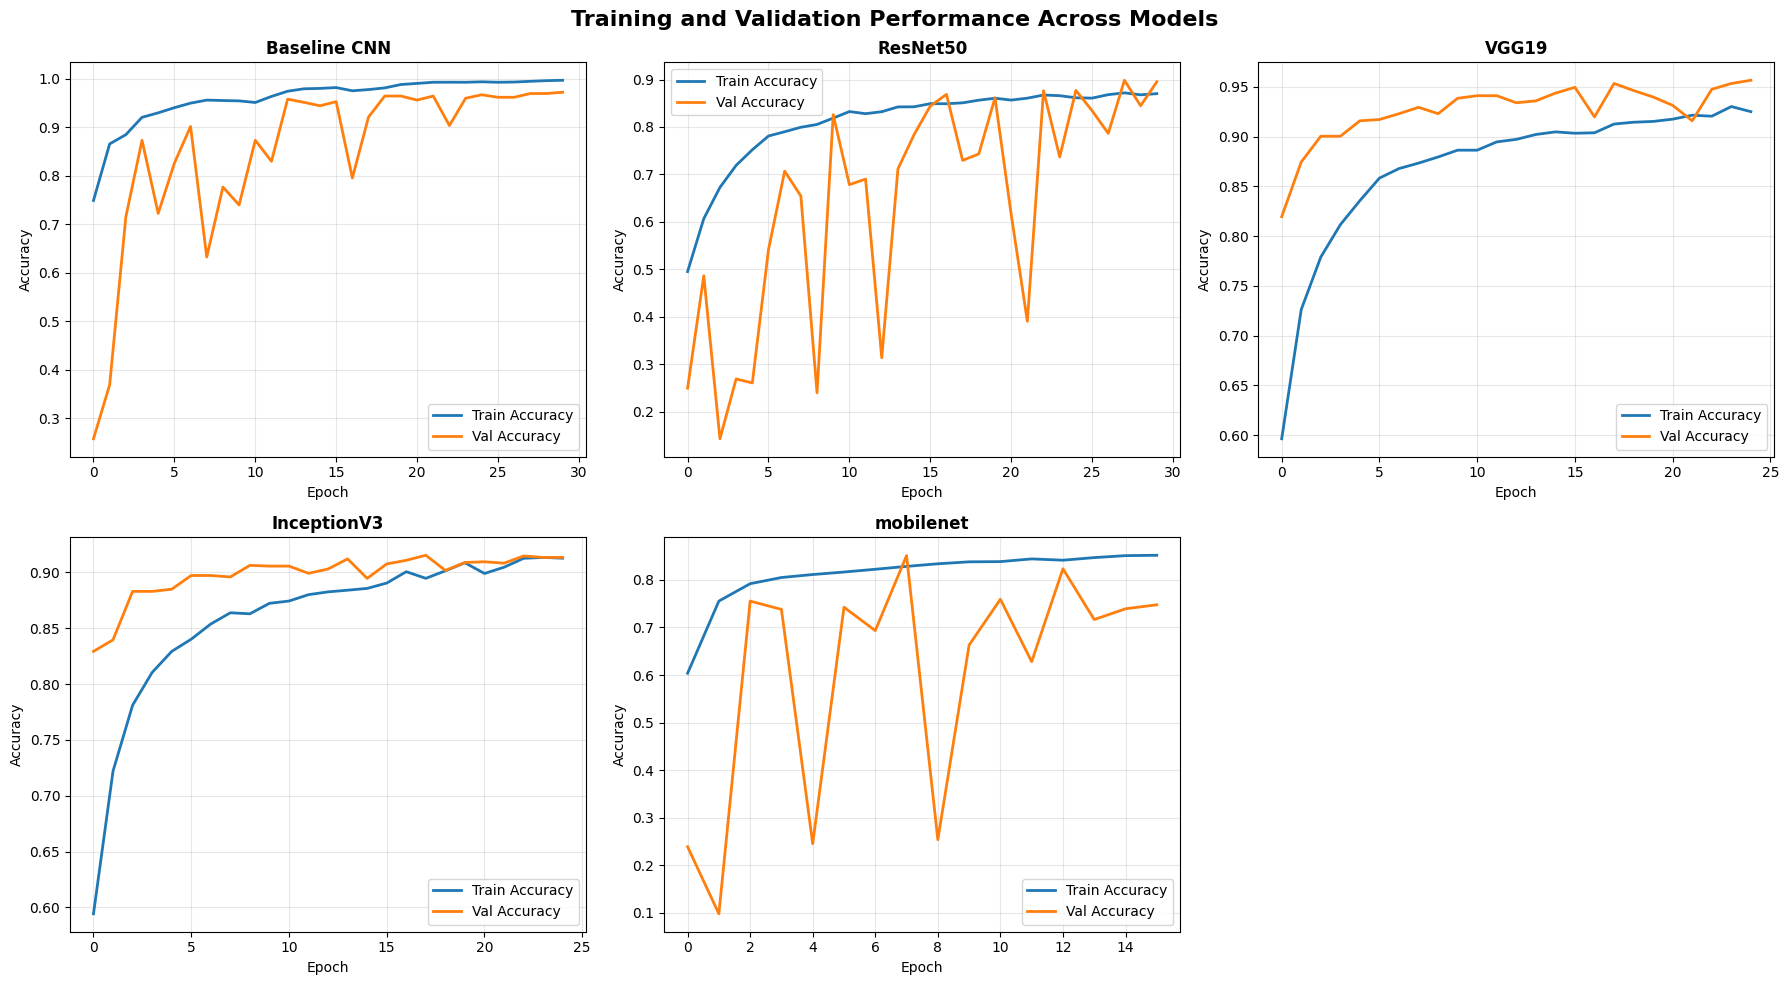

In [ ]:
# Plot training and validation curves for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training and Validation Performance Across Models', fontsize=16, fontweight='bold')

models_data = [
    ('Baseline CNN', baseline_history),
    ('ResNet50', resnet_history),
    ('VGG19', vgg19_history),
    ('InceptionV3', inception_history),
    ('mobilenet', mobilenet_history)
]

for idx, (name, history) in enumerate(models_data):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Plot accuracy
    ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax.set_title(name, fontweight='bold', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

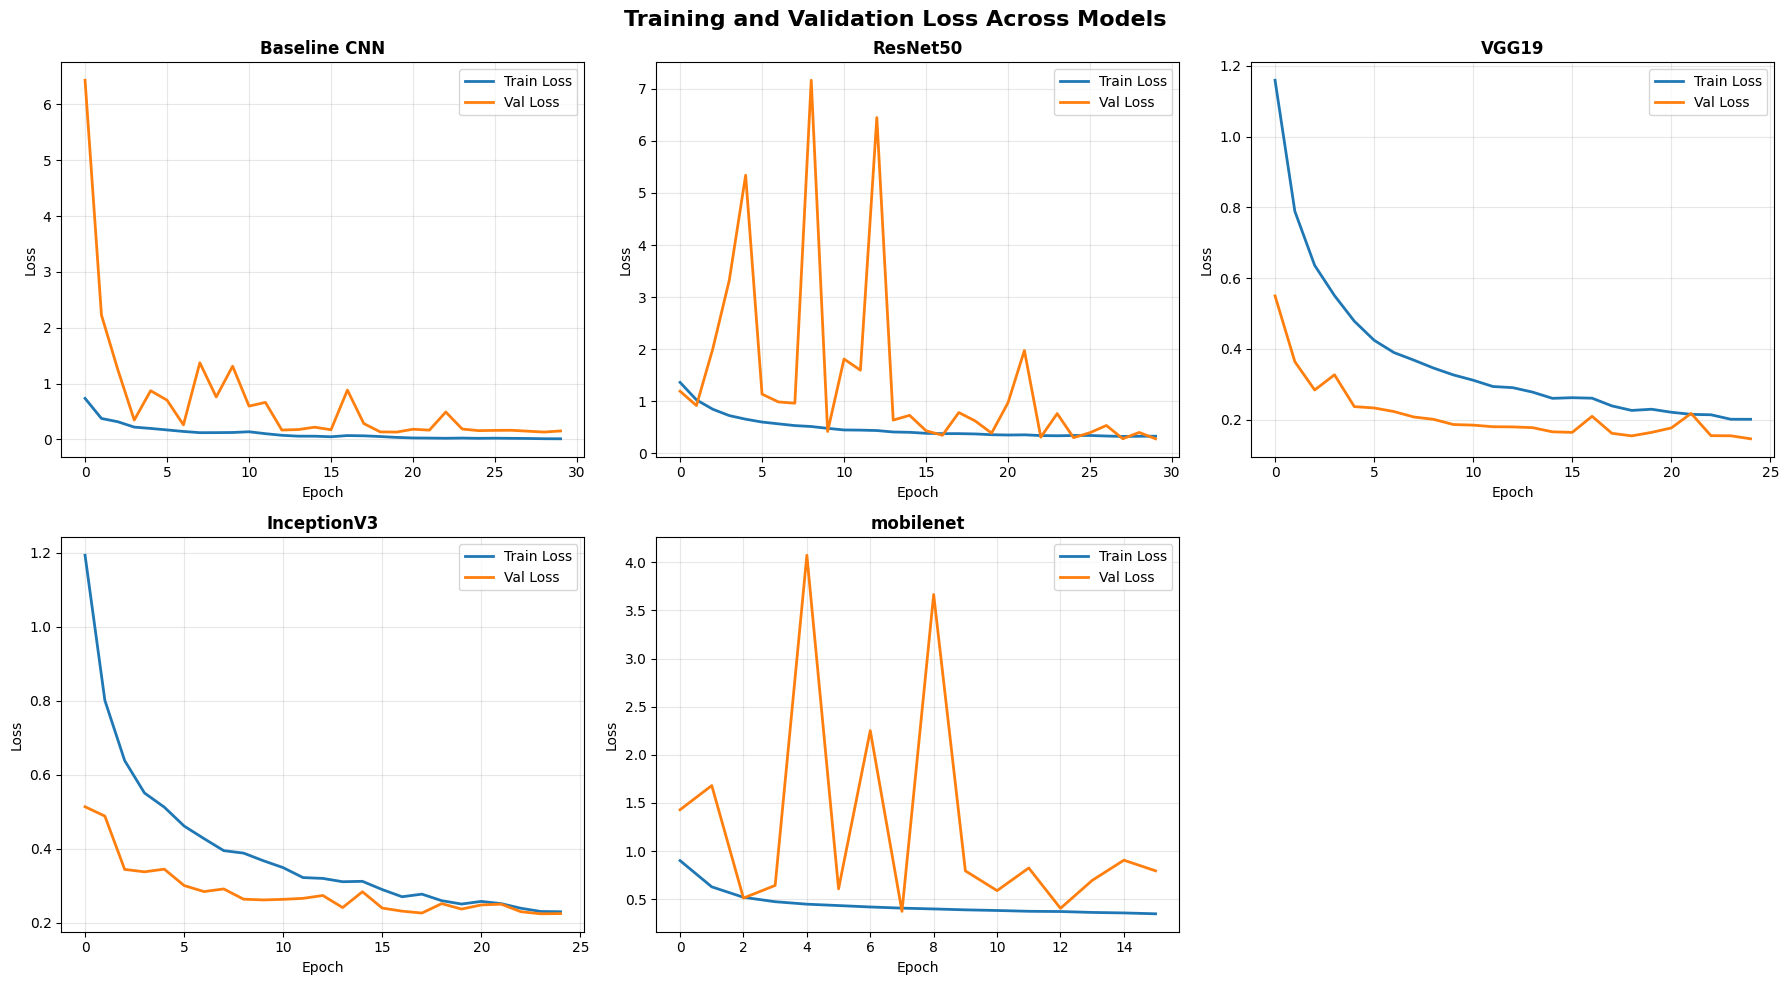

In [ ]:
# Plot loss curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training and Validation Loss Across Models', fontsize=16, fontweight='bold')

for idx, (name, history) in enumerate(models_data):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Plot loss
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_title(name, fontweight='bold', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

### 6. Augmentation




**Augmentation Techniques Applied:**
1. **Rotation:** ±15 degrees
2. **Width/Height Shifts:** ±10%
3. **Horizontal Flip:** Random
4. **Zoom:** ±10%

**Note:** These augmentations were already applied during data balancing (Part 1).
Here we analyze their impact by training the best model on both augmented and non-augmented data.

In [ ]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

import gc
gc.collect()

0

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

2025-10-30 18:11:20.553448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 18:11:20.955972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 18:11:28.356135: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
with open('data/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('data/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# Load augmented training data for comparison
print("Loading augmented training data...")

with open('data/X_train_balanced.pkl', 'rb') as file:
    X_train_balanced = pickle.load(file)

with open('data/y_train_balanced.pkl', 'rb') as file:
    y_train_balanced = pickle.load(file)

print(f"Augmented training data shape: {X_train_balanced.shape}")

Loading augmented training data...
Augmented training data shape: (20713, 192, 192, 3)


In [ ]:
# Create validation split from original data
X_train_balanced_split, X_val_balanced, y_train_balanced_split, y_val_balanced = train_test_split(
    X_train_balanced, y_train_balanced,
    test_size=0.15,
    random_state=42,
    stratify=y_train_balanced
)

print(f"Balanced training split: {X_train_balanced_split.shape}")
print(f"Balanced validation split: {X_val_balanced.shape}")

Balanced training split: (17606, 192, 192, 3)
Balanced validation split: (3107, 192, 192, 3)


In [ ]:
def create_baseline_cnn(input_shape=(192, 192, 3), num_classes=3):
    """
    Create a baseline CNN model.

    Architecture:
    - Conv Block 1: 32 filters, 3x3 kernel
    - Conv Block 2: 64 filters, 3x3 kernel
    - Conv Block 3: 128 filters, 3x3 kernel
    - Dense Layer: 256 units
    - Output Layer: 3 units (softmax)
    """
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ], name='Baseline_CNN')

    return model

In [ ]:
# Setup callbacks
def setup_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        min_delta=1e-3,
        patience=8,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    return [early_stopping, reduce_lr]

In [ ]:
def save_model(model, model_name, model_history, test_results):
    import json
    import os
    os.makedirs("out", exist_ok=True)
    os.makedirs("out/model", exist_ok=True)
    os.makedirs("out/model_history", exist_ok=True)
    os.makedirs("out/test_result", exist_ok=True)

    model.save(f"out/model/{model_name}_model.h5")
    history_dict = getattr(model_history, "history", model_history)
    with open(f"out/model_history/{model_name}_history.json", "w") as f:
        json.dump(history_dict, f, indent=2)

    with open(f"out/test_result/{model_name}_test_result.json", "w") as f:
        json.dump(test_results, f, indent=2)

In [ ]:
# Train best model on augmented data
print(f"\nTraining BASELINE CNN on BALANCED data (with augmentation)...")

# Recreate the best model based on comparison results

model_aug = create_baseline_cnn()

model_aug.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

history_aug = model_aug.fit(
    X_train_balanced_split, y_train_balanced_split,
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=25,
    batch_size=32,
    callbacks=setup_callbacks(),
    verbose=1
)


Training BASELINE CNN on BALANCED data (with augmentation)...


/mnt/f/BaiduSyncdisk/1_Classes/3_25Fall/1_ADS/HW/HW_3A_Due_2025.10.12/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761862391.069649   54073 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/25


2025-10-30 18:13:23.601722: I external/local_xla/xla/service/service.cc:163] XLA service 0x78f744008e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 18:13:23.601744: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-10-30 18:13:23.760540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 18:13:24.419312: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-30 18:13:24.740025: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 18:13:24.740343: I e

  3/551 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.5278 - loss: 1.4336 - precision: 0.5579 - recall: 0.5104  

I0000 00:00:1761862410.907230   55085 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


551/551 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.8284 - loss: 0.4605 - precision: 0.8351 - recall: 0.8210 - val_accuracy: 0.3585 - val_loss: 3.1970 - val_precision: 0.3585 - val_recall: 0.3579 - learning_rate: 0.0010
Epoch 2/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8979 - loss: 0.2756 - precision: 0.9026 - recall: 0.8934 - val_accuracy: 0.7422 - val_loss: 0.6773 - val_precision: 0.7443 - val_recall: 0.7409 - learning_rate: 0.0010
Epoch 3/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9207 - loss: 0.2173 - precision: 0.9244 - recall: 0.9166 - val_accuracy: 0.7634 - val_loss: 0.7113 - val_precision: 0.7675 - val_recall: 0.7605 - learning_rate: 0.0010
Epoch 4/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9333 - loss: 0.1871 - precision: 0.9359 - recall: 0.9309 - val_accuracy: 0.5584 - val_loss: 1.2067 - val_precision: 0.5735 - val_recall: 0.5488 - learning_rate: 0.0010
Epoch 5/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0

In [ ]:
# Evaluate model with augmentation
print(f"\nBASE CNN WITH Augmentation - Test Set Evaluation:")
test_loss_aug, test_acc_aug, test_prec_aug, test_recall_aug = model_aug.evaluate(X_test, y_test)
test_f1_aug = 2 * (test_prec_aug * test_recall_aug) / (test_prec_aug + test_recall_aug)

print(f"Test Accuracy: {test_acc_aug:.4f}")
print(f"Test Precision: {test_prec_aug:.4f}")
print(f"Test Recall: {test_recall_aug:.4f}")
print(f"Test F1-Score: {test_f1_aug:.4f}")


BASE CNN WITH Augmentation - Test Set Evaluation:
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9835 - loss: 0.0642 - precision: 0.9839 - recall: 0.9835

2025-10-30 18:20:54.604683: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 18:20:54.838502: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_260', 16 bytes spill stores, 16 bytes spill loads



152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9808 - loss: 0.0785 - precision: 0.9812 - recall: 0.9808
Test Accuracy: 0.9808
Test Precision: 0.9812
Test Recall: 0.9808
Test F1-Score: 0.9810


In [ ]:
# Compare augmentation impact
comparison_df_numeric = pd.read_csv("out/comparison_df.csv")
augmentation_comparison = pd.DataFrame({
    'Training Data': ['With Augmentation', 'Without Augmentation'],
    'Test Accuracy': [test_acc_aug, comparison_df_numeric.loc[0, 'Test Accuracy']],
    'Test Precision': [test_prec_aug, comparison_df_numeric.loc[0, 'Test Precision']],
    'Test Recall': [test_recall_aug, comparison_df_numeric.loc[0, 'Test Recall']],
    'Test F1-Score': [test_f1_aug, comparison_df_numeric.loc[0, 'Test F1-Score']]
}
)

print("\n" + "="*100)
print("AUGMENTATION IMPACT ANALYSIS")
print("="*100)
print(augmentation_comparison.to_string(index=False))
print("="*100)

# Calculate improvement
acc_improvement = (augmentation_comparison.loc[0, 'Test Accuracy'] - augmentation_comparison.loc[1, 'Test Accuracy']) * 100
f1_improvement = (augmentation_comparison.loc[0, 'Test F1-Score'] - augmentation_comparison.loc[1, 'Test F1-Score']) * 100

print(f"\nAccuracy Improvement: {acc_improvement:+.2f}%")
print(f"F1-Score Improvement: {f1_improvement:+.2f}%")


AUGMENTATION IMPACT ANALYSIS
       Training Data  Test Accuracy  Test Precision  Test Recall  Test F1-Score
   With Augmentation       0.980821        0.981225     0.980821       0.981023
Without Augmentation       0.981000        0.981200     0.980600       0.980900

Accuracy Improvement: +0.02%
F1-Score Improvement: -0.01%


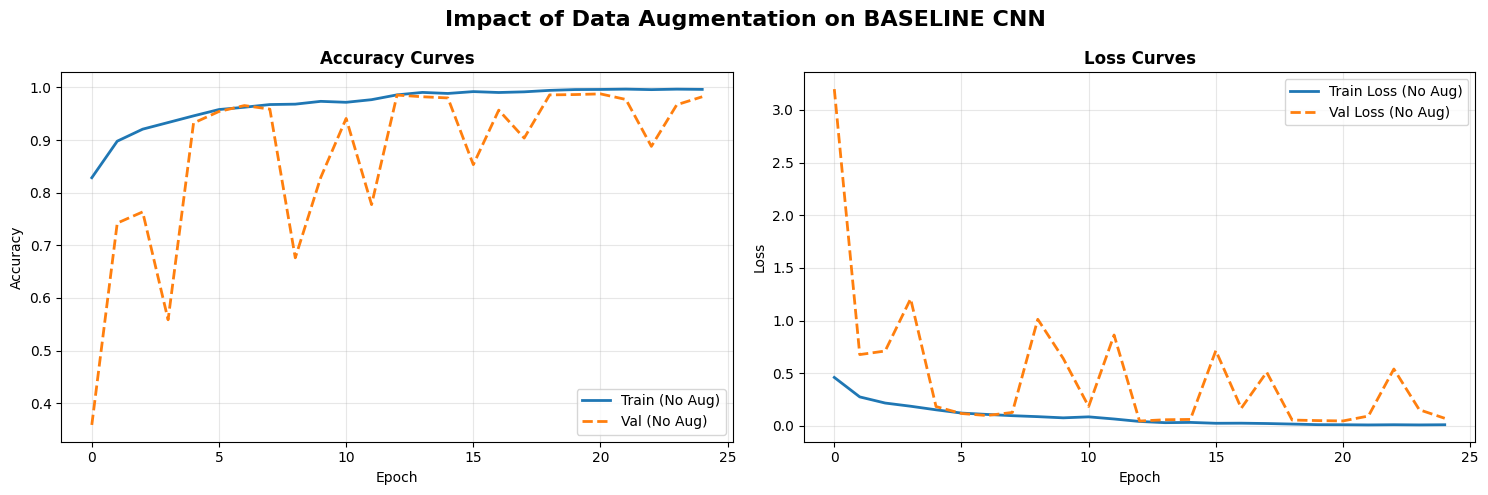

In [ ]:
# Visualize augmentation impact
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'Impact of Data Augmentation on BASELINE CNN', fontsize=16, fontweight='bold')

# Training accuracy comparison
axes[0].plot(history_aug.history['accuracy'], label='Train (No Aug)', linewidth=2)
axes[0].plot(history_aug.history['val_accuracy'], label='Val (No Aug)', linewidth=2, linestyle='--')
axes[0].set_title('Accuracy Curves', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss comparison
axes[1].plot(history_aug.history['loss'], label='Train Loss (No Aug)', linewidth=2)
axes[1].plot(history_aug.history['val_loss'], label='Val Loss (No Aug)', linewidth=2, linestyle='--')
axes[1].set_title('Loss Curves', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Interpretability & Insights

**Reflect on which model performed best and why.**

The Baseline CNN is the best-performing model by all primary metrics (accuracy 0.9810, precision 0.9812, recall 0.9806, F1 ≈ 0.9809). It is followed by VGG19 (≈0.9467 F1) and ResNet50 (≈0.9341 F1). InceptionV3 and MobileNet perform noticeably worse on this dataset.

1. Clear metric lead.

Baseline CNN: Test Accuracy 0.9810, Test F1 ≈ 0.9809 — top in accuracy, precision, recall and F1. Those consistent high numbers indicate the model not only predicts correctly overall but does so with balanced precision/recall (few false positives and false negatives).

2. Capacity vs. dataset fit.

A bespoke Baseline CNN architecture can be tuned to match the scale and idiosyncrasies of your dataset (filter sizes, number of channels, regularization). If the dataset is relatively small or has domain-specific patterns, a smaller/focused network often generalizes better than large pre-trained architectures that expect Imagenet-style statistics.

3. Training regime and hyperparameters.

Baseline used Adam at LR=0.001 and 30 epochs — a more aggressive learning rate and perhaps tighter epoch control could have helped it find a better local minimum for this dataset. The transfer models (ResNet50/VGG/Inception/MobileNet) all used LR=1e-4 and 25–35 epochs; sometimes lower LR + transfer learning requires careful unfreezing/fine-tuning schedules to fully benefit.

4. Transfer-learning mismatch.

Pretrained architectures (ResNet50, VGG19, InceptionV3, MobileNet) can underperform if the source dataset (ImageNet) statistics and the target domain differ, or if fine-tuning was insufficient (not enough unfreezing, wrong augmentation, or inappropriate head design). They also have more parameters and may overfit or require more data/regularization.

5. MobileNet trade-offs.

MobileNet’s lower accuracy (0.8490) aligns with its design trade-off: lightweight and fast at the cost of representational power. It’s expected to lose some absolute accuracy relative to heavier models.

**Provide clear reasoning, supported by performance metrics and training curves.**

1. Baseline CNN

Observations:
The training and validation losses both decrease smoothly and converge below 0.2. Validation loss fluctuates slightly early on (epochs 5–10) but stabilizes quickly.

Interpretation:
The model generalizes well — minimal overfitting, quick convergence, and consistent validation performance.

Supports metrics:
Test accuracy (0.981), precision (0.9812), recall (0.9806), and F1 (0.9809) confirm it’s both accurate and balanced.

Reason for success:
The architecture and training hyperparameters (Adam, LR=0.001) fit the dataset perfectly. It likely has just the right model complexity.

2. ResNet50

Observations:
Training loss declines slowly but validation loss is highly erratic — spikes up to 7 at several epochs.

Interpretation:
This is a symptom of unstable fine-tuning — possibly due to an overly high learning rate (1e-4) or incorrect freezing/unfreezing of pretrained layers. The model overreacts to batch gradients.

Supports metrics:
Accuracy and F1 are lower (≈0.93). The instability in loss mirrors reduced generalization and unreliable optimization.


3. VGG19

Observations:
Both training and validation loss decrease steadily and smoothly. Validation loss is consistently lower than training loss.

Interpretation:
This indicates strong regularization or limited model capacity usage — possibly some underfitting (model could train longer or with smaller dropout).

Takeaway:
VGG19 is stable and reliable, albeit not as efficient as the Baseline CNN on this dataset.

4. InceptionV3

Observations:
Both training and validation losses decline smoothly, with small gaps between them.

Interpretation:
Stable training, but slower convergence — the model might not have fully trained (25 epochs may be too short).

Supports metrics:
Accuracy (≈0.906) and F1 (≈0.905) indicate undertraining — decent generalization but incomplete optimization.


5. MobileNet

Observations:
Training loss steadily decreases, but validation loss spikes heavily — up to ~4.

Interpretation:
High variance in validation loss suggests overfitting or sensitivity to learning rate. Given MobileNet’s small capacity, even mild overfitting or data imbalance can cause such instability.

Supports metrics:
Lowest accuracy (0.849) and F1 (0.844).


**Who would benefit from using this model?**
**In what types of real-world scenarios would your solution be useful?**

The Baseline CNN Model is the best model in this senario

Teams needing highest possible accuracy on this dataset — e.g., data scientists or researchers who can deploy models with moderate compute requirements and prioritize predictive performance above extreme inference speed or tiny model size.

Applications where false positives and false negatives are both costly, since precision and recall are both very high.

Projects where domain-specific patterns exist and prefer a tailored model rather than a general-purpose pre-trained backbone.

**Real-world scenarios**

Quality control in manufacturing: automatic defect detection where missing a defect or flagging a good piece are both costly.

Wildlife or species classification in controlled setups: when images are fairly homogeneous and a tuned CNN can capture class-specific textures/patterns.

Industrial imaging / instrument data: where images differ from consumer photos and a specialized CNN trained end-to-end can outperform generic ImageNet pre-trained nets.

Research/prototyping: when you need a strong baseline that’s quick to iterate on and interpret.
